# AIM:

To train a Resnet18 model to predict if an X-Ray of a patient shows signs of pneumonia.

The work is done using PyTorch in a Jupyter Notebook.



# X-ray dataset description:

The X-ray images used here were downloaded from Kaggle (https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data)

Original Source: https://nihcc.app.box.com/v/ChestXray-NIHCC

The dataset comprise a total of 36684 xrays. 20672 x-rays are without pneumonia and 6012 xrays are with pneumonia




In [50]:
from pathlib import Path
import pydicom
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm


import torch
import torchvision
from torchvision import transforms
import torchmetrics
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt

## X-ray data preprocessing

The following would be done:
1. Inspected the data labels and images
2. Croping of the images to optimize training
3. Standization of the images into 0 - 1 range

    

In [2]:
labels = pd.read_csv('stage_2_train_labels.csv')
labels  = labels.drop_duplicates('patientId')
labels.head(5)


,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [ ]:
#labels[labels['Target'] == 0].shape
#labels[labels['Target'] == 1].shape

#### Plot sample images

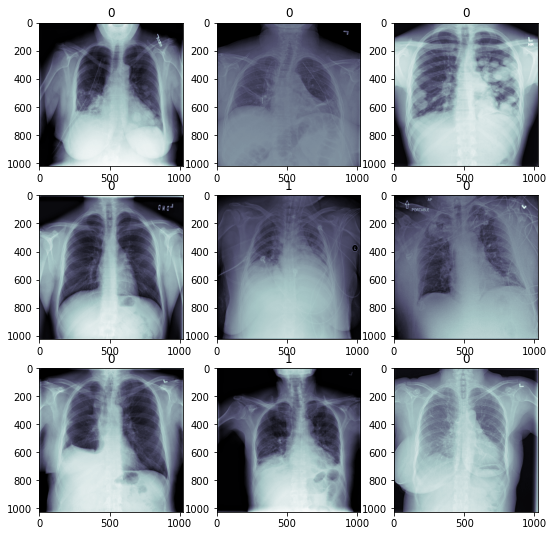

In [3]:
ROOT_PATH = Path("stage_2_train_images/")
SAVE_PATH = Path("Processed/")

fig, axis = plt.subplots(3, 3, figsize=(9,9))
c = 0

for i in range(3):
    for j in range(3):
        patient_id = labels.patientId.iloc[c]
        dcm_path = ROOT_PATH/f'{patient_id}.dcm'
        dcm = pydicom.read_file(dcm_path).pixel_array
        
        label = labels['Target'].iloc[c]
        
        axis[i][j].imshow(dcm, cmap='bone')
        axis[i][j].set_title(label)
        c+=1

#### Standardize, compute statistics for normalization and sepetrate into train and val set

In [ ]:
sums, sums_squared = 0, 0

for n, patient_id in enumerate(tqdm(labels.patientID)):
    patientId = labels.patientId.Iloc[n]
    dcm_path = root_path/f'{patientID}.dcm'
    
    # Read the dicom file with pydicom and standardize the array to the 0 - 1 range
    img = pydicom.dcmread(dcm_path).pixel_array/255
    
    # Resize the image
    img_resized = cv.resize(img, (224, 224)).astype(np.float16)
    label = labels['Target'].iloc[n]
    

    # 4/5 train split, 1/5 val split
    train_or_val = "train" if c < 24000 else "val" 
    
    # Save the array in the corresponding directory
    current_save_path = SAVE_PATH/train_or_val/str(label) 
    current_save_path.mkdir(parents=True, exist_ok=True)
    np.save(current_save_path/patient_id, dcm_array)  
    
    # Compute the statistics to be used for normalizing the images
    normalizer = dcm_array.shape[0] * dcm_array.shape[1]  
    if train_or_val == "train":  
        sums += np.sum(dcm_array) / normalizer
        sums_squared += (np.power(dcm_array, 2).sum()) / normalizer  
        
# Mean and standard deviation

mean = sums / 24000
std = np.sqrt(sums_squared / 24000 - (mean**2))
print(f"Mean of Dataset: {mean}, STD: {std}")

# Data loader to feed data into the training model

In [4]:
def load_file(path):
    return np.load(path).astype(np.float32)

#### Transform dataset and create data folders

In [5]:
train_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize(0.49, 0.248),  # Use mean and std from preprocessing notebook
                                    transforms.RandomAffine( # Data Augmentation
                                        degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
                                        transforms.RandomResizedCrop((224, 224), scale=(0.35, 1))

])

val_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize([0.49], [0.248]),  # Use mean and std from preprocessing notebook
])


train_dataset = torchvision.datasets.DatasetFolder(
    "Processed/train/",
    loader=load_file, extensions="npy", transform=train_transforms)

val_dataset = torchvision.datasets.DatasetFolder(
    "Processed/val/",
    loader=load_file, extensions="npy", transform=val_transforms)

#### Create Data Loaders based on the Folders 

In [6]:
batch_size = 64#TODO
num_workers = 4# TODO

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

print(f"There are {len(train_dataset)} train images and {len(val_dataset)} val images")

There are 24000 train images and 2684 val images


#### Due to data imbalance a class weight is applied

In [7]:
negatives = np.unique(train_dataset.targets, return_counts=True)[1][0]
positives = np.unique(train_dataset.targets, return_counts=True)[1][1]
class_weight = negatives/positives
class_weight

3.4386905862770485

# Creating the classification model

In [19]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self, weight=1):
        super().__init__()
        
        self.model = torchvision.models.resnet18()
        # change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        # change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 1
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))
        
        # simple accuracy computation
        self.train_acc = torchmetrics.Accuracy()
        self.val_acc = torchmetrics.Accuracy()

    def forward(self, data):
        pred = self.model(data)
        return pred
    
    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()  #Convert label to float (just needed for loss computation)
        pred = self(x_ray)[:,0]  # Prediction: Make sure prediction and label have same shape
        loss = self.loss_fn(pred, label)  # Compute the loss
        
        # Log loss and batch accuracy
        self.log("Train Loss", loss)
        self.log("Step Train Acc", self.train_acc(torch.sigmoid(pred), label.int()))
        return loss
    
    
    def training_epoch_end(self, outs):
        # After one epoch compute the whole train_data accuracy
        self.log("Train Acc", self.train_acc.compute())
        
        
    def validation_step(self, batch, batch_idx):
        # Same steps as in the training_step
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0]  # make sure prediction and label have same shape

        loss = self.loss_fn(pred, label)
        
        # Log validation metrics
        self.log("Val Loss", loss)
        self.log("Step Val Acc", self.val_acc(torch.sigmoid(pred), label.int()))
        return loss
    
    def validation_epoch_end(self, outs):
        self.log("Val Acc", self.val_acc.compute())
    
    def configure_optimizers(self):
        #Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]



#### Instantiate the model

In [49]:
model = PneumoniaModel() 


#### A checkpoint to store the 10 best models based on val accuracy

In [10]:
checkpoint_callback = ModelCheckpoint(
    monitor='Val Acc',
    save_top_k=10,
    mode='max')

#### Creating the trainer

In [11]:
trainer = pl.Trainer(accelerator='cpu', logger=TensorBoardLogger(save_dir="./logs"), log_every_n_steps=1,
                     callbacks=checkpoint_callback,
                     max_epochs=35)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [ ]:
trainer.fit(model, train_loader, val_loader)


  | Name      | Type              | Params
------------------------------------------------
0 | model     | ResNet            | 11.2 M
1 | loss_fn   | BCEWithLogitsLoss | 0     
2 | train_acc | Accuracy          | 0     
3 | val_acc   | Accuracy          | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

# Model Evaluation 

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Use strict=False, otherwise we would want to match the pos_weight which is not necessary
model = PneumoniaModel.load_from_checkpoint("weights/weights_1.ckpt")
model.eval()
model.to(device);

In [21]:
preds = []
labels = []

with torch.no_grad():
    for data, label in tqdm(val_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model(data)[0].cpu())
        preds.append(pred)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()


  0%|          | 0/2684 [00:00<?, ?it/s]

In [27]:
acc = torchmetrics.Accuracy()(preds, labels)
precision = torchmetrics.Precision()(preds, labels)
recall = torchmetrics.Recall()(preds, labels)
cm = torchmetrics.ConfusionMatrix(num_classes=2)(preds, labels)
cm_threshed = torchmetrics.ConfusionMatrix(num_classes=2, threshold=0.5)(preds, labels)

print(f"Val Accuracy: {acc}")
print(f"Val Precision: {precision}")
print(f"Val Recall: {recall}")
print(f"Confusion Matrix:\n {cm}")
print(f"Confusion Matrix 2:\n {cm_threshed}")

Val Accuracy: 0.8457525968551636
Val Precision: 0.7002096176147461
Val Recall: 0.5520660877227783
Confusion Matrix:
 tensor([[1936.,  143.],
        [ 271.,  334.]])
Confusion Matrix 2:
 tensor([[1936.,  143.],
        [ 271.,  334.]])


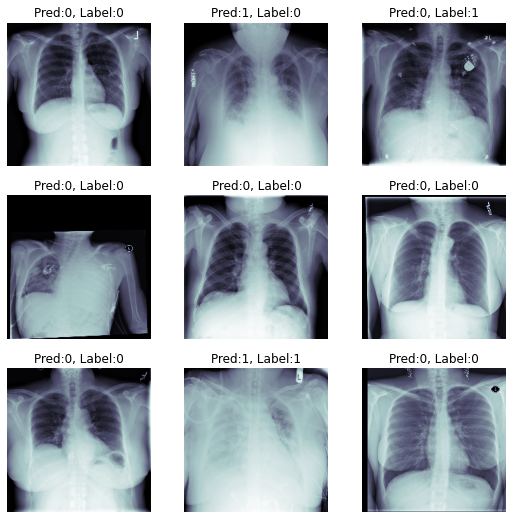

In [29]:
fig, axis = plt.subplots(3, 3, figsize=(9, 9))

for i in range(3):
    for j in range(3):
        rnd_idx = np.random.randint(0, len(preds))
        axis[i][j].imshow(val_dataset[rnd_idx][0][0], cmap="bone")
        axis[i][j].set_title(f"Pred:{int(preds[rnd_idx] > 0.5)}, Label:{labels[rnd_idx]}")
        axis[i][j].axis("off")

# Visualizing the classifier decision with CAM

CAM is claculated by multiplying the output of the last convolutional layer (BasicBlock 1 of layer 4) $A_k$ (consisting of k channels) with the parameters $w$ of the subsequent fully connected layer to compute an activation map $M$:
$$ M = \sum_k w_kA_k$$

#### Accessing the last convolutional layer

In [26]:
list(model.children())[:-2]
torch.nn.Sequential(*list(model.children())[:-2])

Sequential(
  (0): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

#### Feature map is extracted from the foreard pass by implementing a global average pooling and flattening

1. Extracted feature map in forward pass
2. Performed global average pooling
3. Performed model flattening 
4. Performed class prediction

In [34]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        
        self.model = torchvision.models.resnet18()
        
        # Change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        
        # Change out_feature of the last fully connected layer (called fc in resnet18) from 1000 to 1
        self.model.fc = torch.nn.Linear(in_features=512, out_features=1)
        
        # Extract the feature map up to the last convolutional layer (AdaptiveAvgPool2d layer)
        self.feature_map = torch.nn.Sequential(*list(self.model.children())[:-2])    
    
    def forward(self, data):
        
        # Compute feature map
        feature_map = self.feature_map(data)
        
        # Use Adaptive Average Pooling as in the original model
        avg_pool_output = torch.nn.functional.adaptive_avg_pool2d(input=feature_map, output_size=(1, 1))
        print(avg_pool_output.shape)
        
        # Flatten the output into a 512 element vector
        avg_pool_output_flattened = torch.flatten(avg_pool_output)
        print(avg_pool_output_flattened.shape)
        
        # Compute prediction
        pred = self.model.fc(avg_pool_output_flattened)
        return pred, feature_map
    

#### Defining the CAM class

In [45]:
def CAM(model, img):
    
    with torch.no_grad():
        pred, features = model(img.unsqueeze(0))
    b, c, h, w = features.shape
    
    features = features.reshape((c, h*w))
    
    weight_params = list(model.model.fc.parameters())[0]
    weight = weight_params[0].detach()
    print(weight.shape)
    
    cam = torch.matmul(weight, features)
    print(features.shape)
    cam = cam - torch.min(cam)
    cam_img = cam / torch.max(cam)
    # Reshape the class activation map to 512x7x7 and move the tensor back to CPU
    cam_img = cam_img.reshape(h, w).cpu()
    
    return cam_img, torch.sigmoid(pred)


def visualize(img, heatmap, pred):
    
    img = img[0]
    
    heatmap = transforms.functional.resize(heatmap.unsqueeze(0), (img.shape[0], img.shape[1]))[0]
    
    # Create a figure
    fig, axis = plt.subplots(1, 2)
    
    axis[0].imshow(img, cmap="bone")
    # Overlay the original image with the upscaled class activation map
    axis[1].imshow(img, cmap="bone")
    axis[1].imshow(heatmap, alpha=0.5, cmap="jet")
    plt.title(f"Pneumonia: {(pred > 0.5).item()}")

In [46]:
model = PneumoniaModel.load_from_checkpoint("weights/weights_3.ckpt", strict=False)
model.eval();

#### The heatmap focuses on the area that facilitated the pneumonia classification

torch.Size([1, 512, 1, 1])
torch.Size([512])
torch.Size([512])
torch.Size([512, 49])


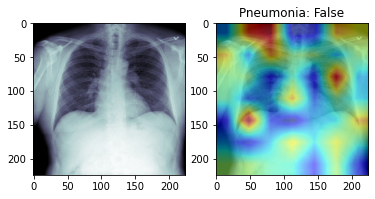

In [54]:
img = val_dataset[50][0]  # Select a subject
activation_map, pred = CAM(model, img)  # Compute the Class activation map given the subject
visualize(img, activation_map, pred)  # Visualize CAM
